##Add image augmentation

This notebook is to create a folder with augmented images of the same structure as the stage1_train.

The augmentation is generated by imgaug python library.



In [21]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
from imgaug import augmenters as iaa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from config import Config
import utils
import model as modellib
import visualize
import skimage.color
import skimage.io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from model import log


%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
## Yizhen's path
TRAIN_PATH = './kaggle-dsbowl-2018-dataset-fixes-master/stage1_train/'
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [22]:
## Yinan's path
TRAIN_PATH = './input/stage1_train/' ## This is the fixed version.
TEST_PATH = './input/stage1_test/'
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [23]:
#create the nuclei dataset

class NucleiDataset(utils.Dataset):
    
    def load_nuclei(self, path, ids):       
        #Add class
        self.add_class("nuclei", 1, "nuclei")

        # Add image
        for i in range(len(ids)):
            path_image = path + ids[i] + '/images/' + ids[i] + '.png'
            mask_path = path + ids[i] + '/masks/'
            self.add_image("nuclei", image_id=i, path=path_image, maskpath=mask_path)
     
     
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])[:, :, :3]
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image       
  
         
    def load_mask(self, i):
        img = self.load_image(i)
        width = img.shape[1]
        height = img.shape[0]
        n = len(next(os.walk(self.image_info[i]['maskpath']))[2])       
        mask = np.zeros((height, width, n), dtype=np.bool)
        for t, mask_file in enumerate(next(os.walk(self.image_info[i]['maskpath']))[2]):            
            mask_ = imread(self.image_info[i]['maskpath'] + mask_file)
            mask[:, :, t:t+1] = np.reshape(mask_,(height,width,1))
        class_ids = np.array([1]*n)
        return mask, class_ids
        

In [25]:

category = './input/classes.csv'
cate = pd.read_csv(category,index_col=False)
#print((cate['foreground'] == 'white') & (cate['background'] == 'black')) 
white_black = cate.loc[(cate['foreground'] == 'white') \
                       & (cate['background'] == 'black'),'filename'].tolist()
purple_yellow = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'yellow') ,'filename'].tolist()
purple_white = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'white') ,'filename'].tolist()
purple_purple = cate.loc[(cate['foreground'] == 'purple') \
                       & (cate['background'] == 'purple') ,'filename'].tolist()
black_white = cate.loc[(cate['foreground'] == 'black') \
                       & (cate['background'] == 'white') ,'filename'].tolist()

print("number of white_black image: %d" %len(white_black))
print("number of purple_yellow image: %d" %len(purple_yellow))
print("number of purple_white image: %d" %len(purple_white))
print("number of purple_purple image: %d" %len(purple_purple))
print("number of black_white image: %d" %len(black_white))


number of white_black image: 599

number of purple_yellow image: 8

number of purple_white image: 41

In [26]:
train_index = [n for i, n in enumerate(train_ids) \
               if n+".png" in white_black[:int(len(white_black)*0.8)]]
val_index = [n for i, n in enumerate(train_ids) \
             if n+".png" in white_black[int(len(white_black)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_yellow[:int(len(purple_yellow)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_yellow[int(len(purple_yellow)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_white[:int(len(purple_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_white[int(len(purple_white)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in purple_purple[:int(len(purple_purple)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in purple_purple[int(len(purple_purple)*0.8):]]
train_index = train_index + [n for i, n in enumerate(train_ids) \
                             if n+".png" in black_white[:int(len(black_white)*0.8)]]
val_index = val_index + [n for i, n in enumerate(train_ids) \
                         if n+".png" in black_white[int(len(black_white)*0.8):]]
print("length of train set: %d" %len(train_index))
print("length of validation set: %d" %len(val_index))
print(bool(set(val_index) & set(train_index)))

length of train set: 531

length of validation set: 133

In [37]:
# Training dataset
dataset_train = NucleiDataset()
dataset_train.load_nuclei(TRAIN_PATH, train_index)
dataset_train.prepare()

# Validation dataset
dataset_val = NucleiDataset()
dataset_val.load_nuclei(TRAIN_PATH, val_index) 
dataset_val.prepare()

###Create sequential image augmentation pipeline.

Can also use iaa.SomeOf, OneOf, Sometimes to add randomness to the image augmentation pipeline (see the API).

In [38]:
import imgaug as ia
from imgaug import augmenters as iaa
import shutil

# Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.8, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.
seq = iaa.Sequential(
    [
        # Note: Somehow crop cannot be applied to mask. 
        # Same for other transform like PerspectiveTransform...
        
        # apply the following augmenters to most images
        iaa.Fliplr(0.8),  # horizontally flip 80% of all images
        iaa.Flipud(0.8),  # vertically flip 90% of all images

        iaa.Affine(
            scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},  # scale images to 70-130% of their size, individually per axis
            translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)},  # translate by -30 to +30 percent (per axis)
            rotate=(-45, 45),  # rotate by -45 to +45 degrees
            shear=(-45, 45),  # shear by -45 to +45 degrees
            order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
            mode='wrap'  # use wrap to fill up
        ),
        
        # execute 1 to 3 of the following augmenters per image
        # mask will skip these augmentation
        iaa.SomeOf((1, 3), [
                iaa.OneOf([
                    iaa.GaussianBlur((0.5, 2)),  # blur images with a sigma between 0.5 and 2
                    iaa.AverageBlur(k=(2, 5)),  # blur image using local means with kernel sizes between 2 and 5
                    iaa.MedianBlur(k=(3, 5)),  # blur image using local medians with kernel sizes between 3 and 5
                ]),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=False),   # add gaussian noise to images
                iaa.Add((-10, 10), per_channel=False),  # change brightness of images (by -10 to 10 of original value)
                iaa.ContrastNormalization((0.8, 1.2), per_channel=False),  # improve or worsen the contrast
            ], random_order=True, name="AdvancedAug")
    ], random_order=True
)


Create a folder to store the augmented images

In [39]:
# Dynamically disable color augmentations on masks- don't apply advanced augmentation to mask
def activator_masks(images, augmenter, parents, default):
    if augmenter.name in ["AdvancedAug"]:
        return False
    else:
        # default value for all other augmenters
        return default
    
    
hooks_masks = ia.HooksImages(activator=activator_masks)


# Generate augmentations and save
def save_aug(image_id, train_index, batch_name):
    
    root_path = "./input/" + batch_name + "/"
    if not os.path.exists(root_path):
        os.mkdir(root_path)
    
    fig_name = train_index[image_id]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

    image_aug_root_path = root_path + fig_name
    image_aug_path = image_aug_root_path + "/images/"
    mask_aug_path = image_aug_root_path + "/masks/"
    
    # if the image root folder exist, delete it and make a new one (i.e. overwirte)
    if os.path.exists(image_aug_root_path):
        shutil.rmtree(image_aug_root_path)
    os.mkdir(image_aug_root_path)
    os.mkdir(image_aug_path) 
    os.mkdir(mask_aug_path) 

    # Augment image and save
    image_file_path = image_aug_path + fig_name + ".png"
    images_aug = seq_det.augment_image(image)
    skimage.io.imsave(image_file_path, images_aug)
    
    # Augment masks and save
    mask_path = mask_aug_path + fig_name
    for i in range(mask.shape[2]):        
        mask_aug = seq_det.augment_image(mask[:,:,i], hooks=hooks_masks).astype(int)
        if mask_aug.sum() != 0: # if this slice does not have positive mask, ignore this slice
            mask_aug[np.where(mask_aug==1)] = 255
            skimage.io.imsave(mask_path + str(i) + ".png", mask_aug)
        else:
            continue

Here only tested one image from the stage1_train folder, can use a loop to create augmented image for each image in this folder.

In [220]:

# every time you run this, the seq will be updated and then fixed.
# seq_det = seq.to_deterministic()


In [40]:
import warnings #too much warnings about saving low contrast images
from tqdm import tqdm

warnings.filterwarnings('ignore')


# START AUGMENTATION! 
batch_name = 'AugBatch1'

print(batch_name)

AugBatch1

In [41]:
# Test the first 10 image
#N_TRAIN = 10

# Augment train set
N_TRAIN = len(train_index)

for id in tqdm(range(N_TRAIN)):
    seq_det = seq.to_deterministic()
    save_aug(id, train_index, batch_name) 

  0%|          | 0/531 [00:00<?, ?it/s]

  0%|          | 1/531 [00:00<02:49,  3.13it/s]

  0%|          | 2/531 [00:00<03:02,  2.90it/s]

  1%|          | 3/531 [00:00<02:43,  3.22it/s]

  1%|          | 4/531 [00:01<02:26,  3.60it/s]

  1%|          | 5/531 [00:01<02:26,  3.59it/s]

  1%|          | 6/531 [00:01<02:19,  3.77it/s]

  1%|▏         | 7/531 [00:02<03:19,  2.62it/s]

  2%|▏         | 8/531 [00:03<03:25,  2.55it/s]

  2%|▏         | 9/531 [00:03<03:13,  2.70it/s]

  2%|▏         | 10/531 [00:03<03:00,  2.88it/s]

  2%|▏         | 11/531 [00:03<03:00,  2.88it/s]

  2%|▏         | 13/531 [00:03<02:39,  3.26it/s]

  3%|▎         | 15/531 [00:13<07:48,  1.10it/s]

  3%|▎         | 16/531 [00:13<07:22,  1.16it/s]

  3%|▎         | 17/531 [00:14<07:18,  1.17it/s]

  3%|▎         | 18/531 [00:14<07:01,  1.22it/s]

  4%|▎         | 19/531 [00:14<06:42,  1.27it/s]

  4%|▍         | 20/531 [00:15<06:32,  1.30it/s]

  4%|▍         | 22/531 [00:15<06:10,  1.38it/s]

  4%|▍         | 23/531 [00:16<06:09,  1.38it/s]

  5%|▍         | 24/531 [00:17<06:00,  1.41it/s]

  5%|▍         | 25/531 [00:17<05:50,  1.44it/s]

  5%|▍         | 26/531 [00:17<05:45,  1.46it/s]

  5%|▌         | 27/531 [00:18<05:36,  1.50it/s]

  5%|▌         | 28/531 [00:30<09:00,  1.08s/it]

  5%|▌         | 29/531 [00:30<08:45,  1.05s/it]

  6%|▌         | 30/531 [00:30<08:30,  1.02s/it]

  6%|▌         | 31/531 [00:32<08:50,  1.06s/it]

  6%|▌         | 33/531 [00:33<08:20,  1.00s/it]

  6%|▋         | 34/531 [00:33<08:15,  1.00it/s]

  7%|▋         | 35/531 [00:34<08:07,  1.02it/s]

  7%|▋         | 36/531 [00:40<09:16,  1.13s/it]

  7%|▋         | 37/531 [00:40<09:06,  1.11s/it]

  7%|▋         | 38/531 [00:41<08:53,  1.08s/it]

  8%|▊         | 40/531 [00:45<09:20,  1.14s/it]

  8%|▊         | 41/531 [00:45<09:09,  1.12s/it]

  8%|▊         | 42/531 [00:46<08:57,  1.10s/it]

  8%|▊         | 43/531 [00:48<09:10,  1.13s/it]

  8%|▊         | 44/531 [00:48<08:59,  1.11s/it]

  8%|▊         | 45/531 [00:49<08:49,  1.09s/it]

  9%|▊         | 46/531 [00:49<08:38,  1.07s/it]

  9%|▉         | 47/531 [00:56<09:44,  1.21s/it]

  9%|▉         | 48/531 [00:56<09:33,  1.19s/it]

  9%|▉         | 50/531 [00:57<09:10,  1.14s/it]

 10%|▉         | 52/531 [00:57<08:49,  1.10s/it]

 10%|▉         | 53/531 [00:57<08:41,  1.09s/it]

 10%|█         | 54/531 [01:06<09:48,  1.23s/it]

 10%|█         | 55/531 [01:07<09:44,  1.23s/it]

 11%|█         | 56/531 [01:07<09:34,  1.21s/it]

 11%|█         | 57/531 [01:39<13:49,  1.75s/it]

 11%|█         | 58/531 [01:40<13:39,  1.73s/it]

 11%|█         | 59/531 [01:43<13:49,  1.76s/it]

 11%|█▏        | 61/531 [01:43<13:20,  1.70s/it]

 12%|█▏        | 62/531 [01:44<13:09,  1.68s/it]

 12%|█▏        | 63/531 [01:44<12:56,  1.66s/it]

 12%|█▏        | 65/531 [01:44<12:32,  1.61s/it]

 12%|█▏        | 66/531 [01:45<12:22,  1.60s/it]

 13%|█▎        | 67/531 [01:45<12:11,  1.58s/it]

 13%|█▎        | 68/531 [01:45<12:00,  1.56s/it]

 13%|█▎        | 69/531 [01:46<11:50,  1.54s/it]

 13%|█▎        | 70/531 [01:46<11:41,  1.52s/it]

 13%|█▎        | 71/531 [01:46<11:32,  1.51s/it]

 14%|█▎        | 72/531 [01:47<11:23,  1.49s/it]

 14%|█▎        | 73/531 [01:47<11:17,  1.48s/it]

 14%|█▍        | 74/531 [01:48<11:08,  1.46s/it]

 14%|█▍        | 75/531 [01:48<10:58,  1.44s/it]

 14%|█▍        | 76/531 [01:48<10:50,  1.43s/it]

 15%|█▍        | 77/531 [01:48<10:42,  1.41s/it]

 15%|█▍        | 78/531 [01:50<10:41,  1.42s/it]

 15%|█▍        | 79/531 [01:50<10:34,  1.40s/it]

 15%|█▌        | 80/531 [01:54<10:43,  1.43s/it]

 15%|█▌        | 81/531 [01:54<10:35,  1.41s/it]

 15%|█▌        | 82/531 [01:54<10:29,  1.40s/it]

 16%|█▌        | 83/531 [01:56<10:27,  1.40s/it]

 16%|█▌        | 84/531 [01:56<10:22,  1.39s/it]

 16%|█▌        | 85/531 [01:57<10:16,  1.38s/it]

 16%|█▌        | 86/531 [01:57<10:10,  1.37s/it]

 16%|█▋        | 87/531 [01:58<10:02,  1.36s/it]

 17%|█▋        | 88/531 [01:58<09:56,  1.35s/it]

 17%|█▋        | 90/531 [01:58<09:42,  1.32s/it]

 17%|█▋        | 91/531 [01:59<09:37,  1.31s/it]

 17%|█▋        | 92/531 [01:59<09:30,  1.30s/it]

 18%|█▊        | 93/531 [01:59<09:24,  1.29s/it]

 18%|█▊        | 94/531 [02:00<09:18,  1.28s/it]

 18%|█▊        | 95/531 [02:00<09:12,  1.27s/it]

 18%|█▊        | 96/531 [02:06<09:33,  1.32s/it]

 18%|█▊        | 97/531 [02:07<09:28,  1.31s/it]

 18%|█▊        | 98/531 [02:07<09:23,  1.30s/it]

 19%|█▊        | 99/531 [02:07<09:17,  1.29s/it]

 19%|█▉        | 100/531 [02:07<09:11,  1.28s/it]

 19%|█▉        | 101/531 [02:08<09:07,  1.27s/it]

 19%|█▉        | 102/531 [02:08<09:01,  1.26s/it]

 19%|█▉        | 103/531 [02:09<08:57,  1.25s/it]

 20%|█▉        | 104/531 [02:09<08:51,  1.25s/it]

 20%|█▉        | 105/531 [02:09<08:46,  1.24s/it]

 20%|█▉        | 106/531 [02:10<08:42,  1.23s/it]

 20%|██        | 107/531 [02:11<08:39,  1.22s/it]

 20%|██        | 108/531 [02:11<08:34,  1.22s/it]

 21%|██        | 109/531 [02:12<08:34,  1.22s/it]

 21%|██        | 110/531 [02:13<08:29,  1.21s/it]

 21%|██        | 111/531 [02:13<08:25,  1.20s/it]

 21%|██        | 112/531 [02:14<08:21,  1.20s/it]

 21%|██▏       | 113/531 [02:15<08:20,  1.20s/it]

 21%|██▏       | 114/531 [02:18<08:27,  1.22s/it]

 22%|██▏       | 115/531 [02:19<08:25,  1.22s/it]

 22%|██▏       | 116/531 [02:20<08:21,  1.21s/it]

 22%|██▏       | 117/531 [02:20<08:17,  1.20s/it]

 22%|██▏       | 118/531 [02:27<08:36,  1.25s/it]

 22%|██▏       | 119/531 [02:28<08:33,  1.25s/it]

 23%|██▎       | 120/531 [02:28<08:28,  1.24s/it]

 23%|██▎       | 121/531 [02:28<08:23,  1.23s/it]

 23%|██▎       | 122/531 [02:28<08:18,  1.22s/it]

 23%|██▎       | 123/531 [02:29<08:14,  1.21s/it]

 23%|██▎       | 124/531 [02:33<08:23,  1.24s/it]

 24%|██▎       | 125/531 [02:33<08:20,  1.23s/it]

 24%|██▎       | 126/531 [02:34<08:15,  1.22s/it]

 24%|██▍       | 127/531 [02:34<08:11,  1.22s/it]

 24%|██▍       | 128/531 [02:34<08:07,  1.21s/it]

 24%|██▍       | 129/531 [02:35<08:04,  1.21s/it]

 24%|██▍       | 130/531 [02:39<08:13,  1.23s/it]

 25%|██▍       | 131/531 [02:40<08:08,  1.22s/it]

 25%|██▍       | 132/531 [02:46<08:24,  1.26s/it]

 25%|██▌       | 133/531 [02:48<08:22,  1.26s/it]

 25%|██▌       | 134/531 [02:48<08:18,  1.26s/it]

 25%|██▌       | 135/531 [02:48<08:14,  1.25s/it]

 26%|██▌       | 136/531 [02:49<08:11,  1.24s/it]

 26%|██▌       | 137/531 [02:49<08:08,  1.24s/it]

 26%|██▌       | 138/531 [03:04<08:46,  1.34s/it]

 26%|██▌       | 139/531 [03:08<08:52,  1.36s/it]

 26%|██▋       | 140/531 [03:08<08:47,  1.35s/it]

 27%|██▋       | 141/531 [03:16<09:04,  1.40s/it]

 27%|██▋       | 142/531 [03:17<09:00,  1.39s/it]

 27%|██▋       | 143/531 [03:17<08:56,  1.38s/it]

 27%|██▋       | 144/531 [03:18<08:52,  1.38s/it]

 27%|██▋       | 145/531 [03:18<08:47,  1.37s/it]

 27%|██▋       | 146/531 [03:19<08:44,  1.36s/it]

 28%|██▊       | 147/531 [03:19<08:42,  1.36s/it]

 28%|██▊       | 148/531 [03:20<08:37,  1.35s/it]

 28%|██▊       | 149/531 [03:20<08:33,  1.34s/it]

 28%|██▊       | 150/531 [03:20<08:29,  1.34s/it]

 28%|██▊       | 151/531 [03:20<08:25,  1.33s/it]

 29%|██▊       | 152/531 [03:21<08:21,  1.32s/it]

 29%|██▉       | 153/531 [03:21<08:17,  1.32s/it]

 29%|██▉       | 154/531 [03:21<08:14,  1.31s/it]

 29%|██▉       | 155/531 [03:22<08:10,  1.31s/it]

 29%|██▉       | 156/531 [03:22<08:06,  1.30s/it]

 30%|██▉       | 157/531 [03:22<08:02,  1.29s/it]

 30%|██▉       | 158/531 [03:23<07:59,  1.29s/it]

 30%|██▉       | 159/531 [03:23<07:56,  1.28s/it]

 30%|███       | 160/531 [03:25<07:55,  1.28s/it]

 30%|███       | 161/531 [03:25<07:51,  1.28s/it]

 31%|███       | 162/531 [03:25<07:49,  1.27s/it]

 31%|███       | 163/531 [03:26<07:45,  1.26s/it]

 31%|███       | 164/531 [03:27<07:43,  1.26s/it]

 31%|███       | 165/531 [03:27<07:40,  1.26s/it]

 31%|███▏      | 166/531 [03:27<07:37,  1.25s/it]

 31%|███▏      | 167/531 [03:35<07:50,  1.29s/it]

 32%|███▏      | 168/531 [03:36<07:48,  1.29s/it]

 32%|███▏      | 169/531 [03:36<07:44,  1.28s/it]

 32%|███▏      | 170/531 [03:37<07:41,  1.28s/it]

 32%|███▏      | 171/531 [03:37<07:38,  1.27s/it]

 32%|███▏      | 172/531 [03:38<07:35,  1.27s/it]

 33%|███▎      | 173/531 [03:38<07:31,  1.26s/it]

 33%|███▎      | 174/531 [03:38<07:28,  1.26s/it]

 33%|███▎      | 175/531 [03:39<07:26,  1.25s/it]

 33%|███▎      | 176/531 [03:40<07:24,  1.25s/it]

 33%|███▎      | 177/531 [03:40<07:21,  1.25s/it]

 34%|███▎      | 178/531 [03:40<07:18,  1.24s/it]

 34%|███▎      | 179/531 [03:41<07:15,  1.24s/it]

 34%|███▍      | 180/531 [03:41<07:12,  1.23s/it]

 34%|███▍      | 181/531 [03:41<07:09,  1.23s/it]

 34%|███▍      | 182/531 [03:50<07:22,  1.27s/it]

 34%|███▍      | 183/531 [03:52<07:23,  1.27s/it]

 35%|███▍      | 184/531 [03:53<07:20,  1.27s/it]

 35%|███▍      | 185/531 [03:53<07:17,  1.26s/it]

 35%|███▌      | 186/531 [03:54<07:14,  1.26s/it]

 35%|███▌      | 187/531 [03:54<07:11,  1.25s/it]

 35%|███▌      | 188/531 [03:54<07:08,  1.25s/it]

 36%|███▌      | 189/531 [03:55<07:06,  1.25s/it]

 36%|███▌      | 190/531 [03:55<07:02,  1.24s/it]

 36%|███▌      | 191/531 [03:56<07:00,  1.24s/it]

 36%|███▌      | 192/531 [04:07<07:16,  1.29s/it]

 36%|███▋      | 193/531 [04:07<07:13,  1.28s/it]

 37%|███▋      | 194/531 [04:09<07:12,  1.28s/it]

 37%|███▋      | 196/531 [04:09<07:06,  1.27s/it]

 37%|███▋      | 197/531 [04:09<07:03,  1.27s/it]

 37%|███▋      | 198/531 [04:10<07:00,  1.26s/it]

 37%|███▋      | 199/531 [04:16<07:07,  1.29s/it]

 38%|███▊      | 200/531 [04:16<07:04,  1.28s/it]

 38%|███▊      | 201/531 [04:17<07:02,  1.28s/it]

 38%|███▊      | 202/531 [04:17<06:59,  1.28s/it]

 38%|███▊      | 203/531 [04:18<06:57,  1.27s/it]

 38%|███▊      | 204/531 [04:18<06:55,  1.27s/it]

 39%|███▊      | 205/531 [04:19<06:52,  1.27s/it]

 39%|███▉      | 207/531 [04:19<06:46,  1.26s/it]

 39%|███▉      | 208/531 [04:20<06:44,  1.25s/it]

 39%|███▉      | 209/531 [04:20<06:41,  1.25s/it]

 40%|███▉      | 210/531 [04:20<06:38,  1.24s/it]

 40%|███▉      | 211/531 [04:21<06:36,  1.24s/it]

 40%|███▉      | 212/531 [04:21<06:33,  1.23s/it]

 40%|████      | 213/531 [04:24<06:35,  1.24s/it]

 40%|████      | 214/531 [04:26<06:34,  1.24s/it]

 40%|████      | 215/531 [04:27<06:33,  1.25s/it]

 41%|████      | 216/531 [04:28<06:30,  1.24s/it]

 41%|████      | 217/531 [04:28<06:28,  1.24s/it]

 41%|████      | 219/531 [04:29<06:23,  1.23s/it]

 41%|████▏     | 220/531 [04:32<06:25,  1.24s/it]

 42%|████▏     | 222/531 [04:33<06:20,  1.23s/it]

 42%|████▏     | 223/531 [04:33<06:18,  1.23s/it]

 42%|████▏     | 224/531 [04:33<06:15,  1.22s/it]

 42%|████▏     | 225/531 [04:34<06:12,  1.22s/it]

 43%|████▎     | 226/531 [04:34<06:10,  1.21s/it]

 43%|████▎     | 228/531 [04:34<06:04,  1.20s/it]

 43%|████▎     | 229/531 [04:35<06:03,  1.20s/it]

 43%|████▎     | 230/531 [04:38<06:04,  1.21s/it]

 44%|████▎     | 231/531 [04:40<06:03,  1.21s/it]

 44%|████▎     | 232/531 [04:40<06:01,  1.21s/it]

 44%|████▍     | 234/531 [04:40<05:56,  1.20s/it]

 44%|████▍     | 236/531 [04:49<06:01,  1.23s/it]

 45%|████▍     | 237/531 [04:49<05:59,  1.22s/it]

 45%|████▍     | 238/531 [04:49<05:57,  1.22s/it]

 45%|████▌     | 239/531 [04:50<05:54,  1.22s/it]

 45%|████▌     | 240/531 [04:50<05:52,  1.21s/it]

 45%|████▌     | 241/531 [04:50<05:50,  1.21s/it]

 46%|████▌     | 242/531 [04:51<05:47,  1.20s/it]

 46%|████▌     | 244/531 [04:51<05:42,  1.19s/it]

 46%|████▌     | 245/531 [04:51<05:40,  1.19s/it]

 46%|████▋     | 246/531 [04:51<05:38,  1.19s/it]

 47%|████▋     | 247/531 [04:54<05:38,  1.19s/it]

 47%|████▋     | 248/531 [04:59<05:41,  1.21s/it]

 47%|████▋     | 249/531 [04:59<05:39,  1.20s/it]

 47%|████▋     | 250/531 [05:08<05:46,  1.23s/it]

 47%|████▋     | 251/531 [05:08<05:44,  1.23s/it]

 47%|████▋     | 252/531 [05:08<05:41,  1.23s/it]

 48%|████▊     | 253/531 [05:13<05:44,  1.24s/it]

 48%|████▊     | 254/531 [05:13<05:42,  1.24s/it]

 48%|████▊     | 255/531 [05:13<05:39,  1.23s/it]

 48%|████▊     | 256/531 [05:14<05:37,  1.23s/it]

 48%|████▊     | 257/531 [05:14<05:35,  1.22s/it]

 49%|████▊     | 258/531 [05:14<05:33,  1.22s/it]

 49%|████▉     | 259/531 [05:15<05:31,  1.22s/it]

 49%|████▉     | 260/531 [05:15<05:28,  1.21s/it]

 49%|████▉     | 261/531 [05:15<05:26,  1.21s/it]

 49%|████▉     | 262/531 [05:16<05:24,  1.21s/it]

 50%|████▉     | 263/531 [05:16<05:22,  1.20s/it]

 50%|████▉     | 264/531 [05:17<05:20,  1.20s/it]

 50%|████▉     | 265/531 [05:19<05:20,  1.21s/it]

 50%|█████     | 266/531 [05:19<05:18,  1.20s/it]

 50%|█████     | 267/531 [05:19<05:16,  1.20s/it]

 50%|█████     | 268/531 [05:43<05:37,  1.28s/it]

 51%|█████     | 269/531 [05:44<05:35,  1.28s/it]

 51%|█████     | 271/531 [05:44<05:30,  1.27s/it]

 51%|█████     | 272/531 [05:44<05:28,  1.27s/it]

 51%|█████▏    | 273/531 [05:45<05:26,  1.26s/it]

 52%|█████▏    | 274/531 [05:46<05:25,  1.27s/it]

 52%|█████▏    | 275/531 [05:46<05:22,  1.26s/it]

 52%|█████▏    | 276/531 [05:47<05:20,  1.26s/it]

 52%|█████▏    | 277/531 [05:47<05:18,  1.25s/it]

 52%|█████▏    | 278/531 [05:47<05:16,  1.25s/it]

 53%|█████▎    | 279/531 [05:51<05:17,  1.26s/it]

 53%|█████▎    | 280/531 [05:51<05:15,  1.26s/it]

 53%|█████▎    | 281/531 [05:58<05:19,  1.28s/it]

 53%|█████▎    | 282/531 [05:59<05:17,  1.28s/it]

 53%|█████▎    | 283/531 [05:59<05:15,  1.27s/it]

 54%|█████▎    | 285/531 [06:00<05:10,  1.26s/it]

 54%|█████▍    | 286/531 [06:07<05:15,  1.29s/it]

 54%|█████▍    | 287/531 [06:08<05:13,  1.28s/it]

 54%|█████▍    | 288/531 [06:08<05:11,  1.28s/it]

 54%|█████▍    | 289/531 [06:09<05:09,  1.28s/it]

 55%|█████▍    | 290/531 [06:10<05:07,  1.28s/it]

 55%|█████▍    | 291/531 [06:10<05:05,  1.27s/it]

 55%|█████▍    | 292/531 [06:11<05:03,  1.27s/it]

 55%|█████▌    | 293/531 [06:11<05:01,  1.27s/it]

 55%|█████▌    | 294/531 [06:11<04:59,  1.27s/it]

 56%|█████▌    | 295/531 [06:12<04:57,  1.26s/it]

 56%|█████▌    | 296/531 [06:12<04:55,  1.26s/it]

 56%|█████▌    | 297/531 [06:14<04:54,  1.26s/it]

 56%|█████▋    | 299/531 [06:14<04:50,  1.25s/it]

 56%|█████▋    | 300/531 [06:14<04:48,  1.25s/it]

 57%|█████▋    | 301/531 [06:14<04:46,  1.25s/it]

 57%|█████▋    | 302/531 [06:15<04:44,  1.24s/it]

 57%|█████▋    | 303/531 [06:15<04:42,  1.24s/it]

 57%|█████▋    | 304/531 [06:15<04:40,  1.24s/it]

 57%|█████▋    | 305/531 [06:21<04:43,  1.25s/it]

 58%|█████▊    | 306/531 [06:22<04:40,  1.25s/it]

 58%|█████▊    | 307/531 [06:22<04:38,  1.25s/it]

 58%|█████▊    | 308/531 [06:22<04:37,  1.24s/it]

 58%|█████▊    | 309/531 [06:25<04:37,  1.25s/it]

 59%|█████▊    | 311/531 [06:26<04:33,  1.24s/it]

 59%|█████▉    | 312/531 [06:26<04:31,  1.24s/it]

 59%|█████▉    | 313/531 [06:26<04:29,  1.24s/it]

 59%|█████▉    | 314/531 [06:32<04:31,  1.25s/it]

 59%|█████▉    | 315/531 [06:33<04:29,  1.25s/it]

 60%|█████▉    | 316/531 [06:33<04:27,  1.24s/it]

 60%|█████▉    | 317/531 [06:36<04:27,  1.25s/it]

 60%|█████▉    | 318/531 [06:37<04:26,  1.25s/it]

 60%|██████    | 319/531 [06:37<04:24,  1.25s/it]

 60%|██████    | 320/531 [06:38<04:22,  1.24s/it]

 60%|██████    | 321/531 [06:38<04:20,  1.24s/it]

 61%|██████    | 322/531 [06:38<04:18,  1.24s/it]

 61%|██████    | 323/531 [06:38<04:16,  1.23s/it]

 61%|██████    | 324/531 [06:39<04:14,  1.23s/it]

 61%|██████    | 325/531 [06:39<04:13,  1.23s/it]

 61%|██████▏   | 326/531 [06:39<04:11,  1.23s/it]

 62%|██████▏   | 327/531 [06:40<04:09,  1.22s/it]

 62%|██████▏   | 328/531 [06:40<04:07,  1.22s/it]

 62%|██████▏   | 329/531 [06:40<04:05,  1.22s/it]

 62%|██████▏   | 330/531 [06:41<04:04,  1.22s/it]

 62%|██████▏   | 331/531 [06:42<04:03,  1.22s/it]

 63%|██████▎   | 332/531 [06:42<04:01,  1.21s/it]

 63%|██████▎   | 333/531 [06:42<03:59,  1.21s/it]

 63%|██████▎   | 334/531 [06:43<03:58,  1.21s/it]

 63%|██████▎   | 335/531 [06:44<03:56,  1.21s/it]

 63%|██████▎   | 336/531 [06:46<03:56,  1.21s/it]

 63%|██████▎   | 337/531 [06:46<03:54,  1.21s/it]

 64%|██████▎   | 338/531 [07:12<04:06,  1.28s/it]

 64%|██████▍   | 339/531 [07:19<04:08,  1.30s/it]

 64%|██████▍   | 340/531 [07:19<04:07,  1.29s/it]

 64%|██████▍   | 342/531 [07:20<04:03,  1.29s/it]

 65%|██████▍   | 343/531 [07:20<04:01,  1.29s/it]

 65%|██████▍   | 344/531 [07:21<03:59,  1.28s/it]

 65%|██████▍   | 345/531 [07:21<03:58,  1.28s/it]

 65%|██████▌   | 346/531 [07:21<03:56,  1.28s/it]

 65%|██████▌   | 347/531 [07:22<03:54,  1.27s/it]

 66%|██████▌   | 348/531 [07:22<03:52,  1.27s/it]

 66%|██████▌   | 349/531 [07:22<03:50,  1.27s/it]

 66%|██████▌   | 350/531 [07:22<03:49,  1.27s/it]

 66%|██████▋   | 352/531 [07:23<03:45,  1.26s/it]

 66%|██████▋   | 353/531 [07:23<03:43,  1.26s/it]

 67%|██████▋   | 354/531 [07:27<03:43,  1.26s/it]

 67%|██████▋   | 355/531 [07:27<03:41,  1.26s/it]

 67%|██████▋   | 356/531 [07:28<03:40,  1.26s/it]

 67%|██████▋   | 357/531 [07:28<03:38,  1.26s/it]

 67%|██████▋   | 358/531 [07:29<03:37,  1.25s/it]

 68%|██████▊   | 359/531 [07:29<03:35,  1.25s/it]

 68%|██████▊   | 360/531 [07:29<03:33,  1.25s/it]

 68%|██████▊   | 361/531 [07:30<03:32,  1.25s/it]

 68%|██████▊   | 362/531 [07:30<03:30,  1.24s/it]

 68%|██████▊   | 363/531 [07:35<03:30,  1.25s/it]

 69%|██████▊   | 364/531 [07:35<03:28,  1.25s/it]

 69%|██████▉   | 366/531 [07:36<03:25,  1.25s/it]

 69%|██████▉   | 367/531 [07:36<03:23,  1.24s/it]

 69%|██████▉   | 368/531 [07:36<03:22,  1.24s/it]

 69%|██████▉   | 369/531 [07:37<03:20,  1.24s/it]

 70%|██████▉   | 370/531 [07:37<03:19,  1.24s/it]

 70%|██████▉   | 371/531 [07:38<03:17,  1.23s/it]

 70%|███████   | 372/531 [07:38<03:16,  1.23s/it]

 70%|███████   | 373/531 [07:39<03:14,  1.23s/it]

 70%|███████   | 374/531 [07:39<03:13,  1.23s/it]

 71%|███████   | 375/531 [07:40<03:11,  1.23s/it]

 71%|███████   | 376/531 [07:40<03:09,  1.23s/it]

 71%|███████   | 377/531 [07:40<03:08,  1.22s/it]

 71%|███████   | 378/531 [07:46<03:08,  1.23s/it]

 71%|███████▏  | 379/531 [07:46<03:07,  1.23s/it]

 72%|███████▏  | 380/531 [07:46<03:05,  1.23s/it]

 72%|███████▏  | 381/531 [07:47<03:03,  1.23s/it]

 72%|███████▏  | 382/531 [07:47<03:02,  1.22s/it]

 72%|███████▏  | 383/531 [07:48<03:00,  1.22s/it]

 72%|███████▏  | 384/531 [07:54<03:01,  1.24s/it]

 73%|███████▎  | 385/531 [07:55<03:00,  1.23s/it]

 73%|███████▎  | 387/531 [07:55<02:56,  1.23s/it]

 73%|███████▎  | 388/531 [07:55<02:55,  1.23s/it]

 73%|███████▎  | 389/531 [07:56<02:53,  1.22s/it]

 73%|███████▎  | 390/531 [07:56<02:52,  1.22s/it]

 74%|███████▎  | 391/531 [07:56<02:50,  1.22s/it]

 74%|███████▍  | 393/531 [07:56<02:47,  1.21s/it]

 74%|███████▍  | 394/531 [07:56<02:45,  1.21s/it]

 74%|███████▍  | 395/531 [07:57<02:44,  1.21s/it]

 75%|███████▍  | 396/531 [07:58<02:43,  1.21s/it]

 75%|███████▍  | 397/531 [07:59<02:41,  1.21s/it]

 75%|███████▍  | 398/531 [07:59<02:40,  1.20s/it]

 75%|███████▌  | 399/531 [07:59<02:38,  1.20s/it]

 75%|███████▌  | 400/531 [08:00<02:37,  1.20s/it]

 76%|███████▌  | 401/531 [08:01<02:36,  1.20s/it]

 76%|███████▌  | 402/531 [08:02<02:34,  1.20s/it]

 76%|███████▌  | 403/531 [08:02<02:33,  1.20s/it]

 76%|███████▌  | 404/531 [08:02<02:31,  1.20s/it]

 76%|███████▋  | 405/531 [08:03<02:30,  1.19s/it]

 76%|███████▋  | 406/531 [08:14<02:32,  1.22s/it]

 77%|███████▋  | 407/531 [08:14<02:30,  1.22s/it]

 77%|███████▋  | 408/531 [08:15<02:29,  1.21s/it]

 77%|███████▋  | 409/531 [08:15<02:27,  1.21s/it]

 77%|███████▋  | 410/531 [08:20<02:27,  1.22s/it]

 77%|███████▋  | 411/531 [08:20<02:26,  1.22s/it]

 78%|███████▊  | 412/531 [08:21<02:24,  1.22s/it]

 78%|███████▊  | 413/531 [08:21<02:23,  1.22s/it]

 78%|███████▊  | 414/531 [08:21<02:21,  1.21s/it]

 78%|███████▊  | 415/531 [08:24<02:21,  1.22s/it]

 78%|███████▊  | 416/531 [08:25<02:19,  1.21s/it]

 79%|███████▊  | 417/531 [08:25<02:18,  1.21s/it]

 79%|███████▊  | 418/531 [08:25<02:16,  1.21s/it]

 79%|███████▉  | 419/531 [08:26<02:15,  1.21s/it]

 79%|███████▉  | 420/531 [08:26<02:13,  1.21s/it]

 79%|███████▉  | 421/531 [08:26<02:12,  1.20s/it]

 79%|███████▉  | 422/531 [08:27<02:10,  1.20s/it]

 80%|███████▉  | 423/531 [08:27<02:09,  1.20s/it]

 80%|███████▉  | 424/531 [08:27<02:08,  1.20s/it]

 80%|████████  | 425/531 [08:32<02:07,  1.21s/it]

 80%|████████  | 426/531 [08:32<02:06,  1.20s/it]

 80%|████████  | 427/531 [08:32<02:04,  1.20s/it]

 81%|████████  | 429/531 [08:33<02:02,  1.20s/it]

 81%|████████  | 430/531 [08:33<02:00,  1.19s/it]

 81%|████████  | 431/531 [08:33<01:59,  1.19s/it]

 81%|████████▏ | 432/531 [08:34<01:57,  1.19s/it]

 82%|████████▏ | 433/531 [08:35<01:56,  1.19s/it]

 82%|████████▏ | 434/531 [08:35<01:55,  1.19s/it]

 82%|████████▏ | 435/531 [08:36<01:53,  1.19s/it]

 82%|████████▏ | 436/531 [08:37<01:52,  1.19s/it]

 82%|████████▏ | 437/531 [08:38<01:51,  1.19s/it]

 82%|████████▏ | 438/531 [08:38<01:50,  1.18s/it]

 83%|████████▎ | 439/531 [08:39<01:48,  1.18s/it]

 83%|████████▎ | 440/531 [08:39<01:47,  1.18s/it]

 83%|████████▎ | 441/531 [08:40<01:46,  1.18s/it]

 83%|████████▎ | 442/531 [08:40<01:44,  1.18s/it]

 83%|████████▎ | 443/531 [08:41<01:43,  1.18s/it]

 84%|████████▎ | 444/531 [08:41<01:42,  1.18s/it]

 84%|████████▍ | 445/531 [08:42<01:40,  1.17s/it]

 84%|████████▍ | 446/531 [08:43<01:39,  1.17s/it]

 84%|████████▍ | 447/531 [08:43<01:38,  1.17s/it]

 84%|████████▍ | 448/531 [08:44<01:37,  1.17s/it]

 85%|████████▍ | 449/531 [08:45<01:35,  1.17s/it]

 85%|████████▍ | 450/531 [08:46<01:34,  1.17s/it]

 85%|████████▍ | 451/531 [08:46<01:33,  1.17s/it]

 85%|████████▌ | 452/531 [08:47<01:32,  1.17s/it]

 85%|████████▌ | 453/531 [08:47<01:30,  1.16s/it]

 85%|████████▌ | 454/531 [08:48<01:29,  1.16s/it]

 86%|████████▌ | 455/531 [08:49<01:28,  1.16s/it]

 86%|████████▌ | 456/531 [08:49<01:27,  1.16s/it]

 86%|████████▌ | 457/531 [08:49<01:25,  1.16s/it]

 86%|████████▋ | 458/531 [08:50<01:24,  1.16s/it]

 86%|████████▋ | 459/531 [08:51<01:23,  1.16s/it]

 87%|████████▋ | 460/531 [08:51<01:22,  1.16s/it]

 87%|████████▋ | 461/531 [08:52<01:20,  1.16s/it]

 87%|████████▋ | 462/531 [08:53<01:19,  1.15s/it]

 87%|████████▋ | 463/531 [08:54<01:18,  1.15s/it]

 87%|████████▋ | 464/531 [08:54<01:17,  1.15s/it]

 88%|████████▊ | 465/531 [08:54<01:15,  1.15s/it]

 88%|████████▊ | 466/531 [08:54<01:14,  1.15s/it]

 88%|████████▊ | 467/531 [08:55<01:13,  1.15s/it]

 88%|████████▊ | 468/531 [08:55<01:12,  1.14s/it]

 88%|████████▊ | 469/531 [08:55<01:10,  1.14s/it]

 89%|████████▊ | 470/531 [08:55<01:09,  1.14s/it]

 89%|████████▊ | 471/531 [08:56<01:08,  1.14s/it]

 89%|████████▉ | 472/531 [08:57<01:07,  1.14s/it]

 89%|████████▉ | 473/531 [08:58<01:06,  1.14s/it]

 89%|████████▉ | 474/531 [08:58<01:04,  1.14s/it]

 89%|████████▉ | 475/531 [08:59<01:03,  1.13s/it]

 90%|████████▉ | 476/531 [09:00<01:02,  1.13s/it]

 90%|████████▉ | 477/531 [09:00<01:01,  1.13s/it]

 90%|█████████ | 478/531 [09:00<00:59,  1.13s/it]

 90%|█████████ | 479/531 [09:00<00:58,  1.13s/it]

 90%|█████████ | 480/531 [09:00<00:57,  1.13s/it]

 91%|█████████ | 481/531 [09:01<00:56,  1.13s/it]

 91%|█████████ | 482/531 [09:01<00:55,  1.12s/it]

 91%|█████████ | 483/531 [09:02<00:53,  1.12s/it]

 91%|█████████ | 484/531 [09:02<00:52,  1.12s/it]

 91%|█████████▏| 485/531 [09:03<00:51,  1.12s/it]

 92%|█████████▏| 486/531 [09:03<00:50,  1.12s/it]

 92%|█████████▏| 487/531 [09:03<00:49,  1.12s/it]

 92%|█████████▏| 488/531 [09:04<00:47,  1.11s/it]

 92%|█████████▏| 489/531 [09:04<00:46,  1.11s/it]

 92%|█████████▏| 490/531 [09:05<00:45,  1.11s/it]

 92%|█████████▏| 491/531 [09:06<00:44,  1.11s/it]

 93%|█████████▎| 492/531 [09:06<00:43,  1.11s/it]

 93%|█████████▎| 493/531 [09:08<00:42,  1.11s/it]

 93%|█████████▎| 494/531 [09:08<00:41,  1.11s/it]

 93%|█████████▎| 495/531 [09:08<00:39,  1.11s/it]

 93%|█████████▎| 496/531 [09:09<00:38,  1.11s/it]

 94%|█████████▎| 497/531 [09:09<00:37,  1.11s/it]

 94%|█████████▍| 498/531 [09:09<00:36,  1.10s/it]

 94%|█████████▍| 499/531 [09:10<00:35,  1.10s/it]

 94%|█████████▍| 500/531 [09:10<00:34,  1.10s/it]

 94%|█████████▍| 501/531 [09:11<00:32,  1.10s/it]

 95%|█████████▍| 502/531 [09:11<00:31,  1.10s/it]

 95%|█████████▍| 503/531 [09:12<00:30,  1.10s/it]

 95%|█████████▍| 504/531 [09:13<00:29,  1.10s/it]

 95%|█████████▌| 505/531 [09:14<00:28,  1.10s/it]

 95%|█████████▌| 506/531 [09:14<00:27,  1.10s/it]

 95%|█████████▌| 507/531 [09:14<00:26,  1.09s/it]

 96%|█████████▌| 508/531 [09:14<00:25,  1.09s/it]

 96%|█████████▌| 509/531 [09:15<00:24,  1.09s/it]

 96%|█████████▌| 510/531 [09:15<00:22,  1.09s/it]

 96%|█████████▌| 511/531 [09:15<00:21,  1.09s/it]

 96%|█████████▋| 512/531 [09:15<00:20,  1.09s/it]

 97%|█████████▋| 513/531 [09:16<00:19,  1.08s/it]

 97%|█████████▋| 514/531 [09:16<00:18,  1.08s/it]

 97%|█████████▋| 515/531 [09:17<00:17,  1.08s/it]

 97%|█████████▋| 516/531 [09:18<00:16,  1.08s/it]

 97%|█████████▋| 517/531 [09:18<00:15,  1.08s/it]

 98%|█████████▊| 518/531 [09:19<00:14,  1.08s/it]

 98%|█████████▊| 519/531 [09:20<00:12,  1.08s/it]

 98%|█████████▊| 520/531 [09:30<00:12,  1.10s/it]

 98%|█████████▊| 521/531 [09:38<00:11,  1.11s/it]

 98%|█████████▊| 522/531 [09:42<00:10,  1.12s/it]

 98%|█████████▊| 523/531 [09:56<00:09,  1.14s/it]

 99%|█████████▊| 524/531 [10:21<00:08,  1.19s/it]

 99%|█████████▉| 525/531 [10:33<00:07,  1.21s/it]

 99%|█████████▉| 526/531 [10:41<00:06,  1.22s/it]

 99%|█████████▉| 527/531 [10:53<00:04,  1.24s/it]

 99%|█████████▉| 528/531 [11:03<00:03,  1.26s/it]

100%|█████████▉| 529/531 [11:13<00:02,  1.27s/it]

100%|█████████▉| 530/531 [11:21<00:01,  1.28s/it]

100%|██████████| 531/531 [11:37<00:00,  1.31s/it]

In [42]:
# Augment validation set
N_VAL = len(val_index)

for id in tqdm(range(N_VAL)):
    seq_det = seq.to_deterministic()
    save_aug(id, val_index, batch_name) 

  0%|          | 0/133 [00:00<?, ?it/s]

  1%|          | 1/133 [00:00<00:39,  3.33it/s]

  2%|▏         | 2/133 [00:00<00:44,  2.96it/s]

  2%|▏         | 3/133 [00:00<00:42,  3.07it/s]

  3%|▎         | 4/133 [00:01<00:37,  3.44it/s]

  4%|▍         | 5/133 [00:01<00:37,  3.44it/s]

  5%|▍         | 6/133 [00:01<00:35,  3.61it/s]

  5%|▌         | 7/133 [00:03<00:57,  2.17it/s]

  6%|▌         | 8/133 [00:03<00:58,  2.15it/s]

  7%|▋         | 9/133 [00:03<00:54,  2.26it/s]

  8%|▊         | 10/133 [00:04<00:51,  2.39it/s]

  8%|▊         | 11/133 [00:04<00:52,  2.31it/s]

 10%|▉         | 13/133 [00:04<00:45,  2.66it/s]

 11%|█         | 14/133 [00:04<00:42,  2.81it/s]

 11%|█▏        | 15/133 [00:17<02:21,  1.20s/it]

 12%|█▏        | 16/133 [00:18<02:11,  1.13s/it]

 13%|█▎        | 17/133 [00:18<02:05,  1.09s/it]

 14%|█▎        | 18/133 [00:18<01:59,  1.03s/it]

 15%|█▌        | 20/133 [00:19<01:47,  1.05it/s]

 17%|█▋        | 22/133 [00:19<01:37,  1.13it/s]

 17%|█▋        | 23/133 [00:19<01:35,  1.15it/s]

 18%|█▊        | 24/133 [00:20<01:31,  1.19it/s]

 19%|█▉        | 25/133 [00:20<01:27,  1.23it/s]

 20%|█▉        | 26/133 [00:20<01:24,  1.26it/s]

 20%|██        | 27/133 [00:20<01:21,  1.30it/s]

 21%|██        | 28/133 [00:38<02:24,  1.38s/it]

 22%|██▏       | 29/133 [00:38<02:19,  1.34s/it]

 23%|██▎       | 30/133 [00:39<02:14,  1.31s/it]

 23%|██▎       | 31/133 [00:41<02:15,  1.33s/it]

 24%|██▍       | 32/133 [00:41<02:10,  1.29s/it]

 25%|██▍       | 33/133 [00:41<02:05,  1.26s/it]

 26%|██▌       | 34/133 [00:42<02:04,  1.26s/it]

 26%|██▋       | 35/133 [00:43<02:01,  1.24s/it]

 27%|██▋       | 36/133 [00:50<02:15,  1.40s/it]

 28%|██▊       | 37/133 [00:50<02:11,  1.37s/it]

 29%|██▊       | 38/133 [00:50<02:06,  1.34s/it]

 29%|██▉       | 39/133 [00:50<02:02,  1.30s/it]

 30%|███       | 40/133 [00:56<02:10,  1.40s/it]

 31%|███       | 41/133 [00:56<02:06,  1.38s/it]

 32%|███▏      | 42/133 [00:56<02:02,  1.35s/it]

 32%|███▏      | 43/133 [01:00<02:06,  1.41s/it]

 33%|███▎      | 44/133 [01:01<02:03,  1.39s/it]

 34%|███▍      | 45/133 [01:01<01:59,  1.36s/it]

 35%|███▍      | 46/133 [01:01<01:56,  1.34s/it]

 35%|███▌      | 47/133 [01:08<02:04,  1.45s/it]

 36%|███▌      | 48/133 [01:08<02:01,  1.42s/it]

 38%|███▊      | 50/133 [01:08<01:53,  1.37s/it]

 38%|███▊      | 51/133 [01:08<01:50,  1.35s/it]

 39%|███▉      | 52/133 [01:08<01:47,  1.32s/it]

 40%|███▉      | 53/133 [01:09<01:44,  1.31s/it]

 41%|████      | 54/133 [01:17<01:53,  1.44s/it]

 41%|████▏     | 55/133 [01:18<01:51,  1.43s/it]

 42%|████▏     | 56/133 [01:18<01:48,  1.41s/it]

 43%|████▎     | 57/133 [01:51<02:28,  1.95s/it]

 44%|████▎     | 58/133 [01:52<02:25,  1.95s/it]

 44%|████▍     | 59/133 [01:56<02:25,  1.97s/it]

 45%|████▌     | 60/133 [01:56<02:21,  1.94s/it]

 47%|████▋     | 62/133 [01:56<02:13,  1.89s/it]

 47%|████▋     | 63/133 [01:57<02:10,  1.86s/it]

 48%|████▊     | 64/133 [01:57<02:06,  1.83s/it]

 49%|████▉     | 65/133 [01:57<02:03,  1.81s/it]

 50%|████▉     | 66/133 [01:58<02:00,  1.80s/it]

 50%|█████     | 67/133 [01:58<01:57,  1.77s/it]

 51%|█████     | 68/133 [01:59<01:53,  1.75s/it]

 52%|█████▏    | 69/133 [01:59<01:50,  1.73s/it]

 53%|█████▎    | 70/133 [02:00<01:48,  1.71s/it]

 53%|█████▎    | 71/133 [02:00<01:45,  1.70s/it]

 54%|█████▍    | 72/133 [02:00<01:42,  1.68s/it]

 55%|█████▍    | 73/133 [02:01<01:39,  1.66s/it]

 56%|█████▌    | 74/133 [02:01<01:36,  1.64s/it]

 56%|█████▋    | 75/133 [02:01<01:33,  1.62s/it]

 57%|█████▋    | 76/133 [02:01<01:31,  1.60s/it]

 58%|█████▊    | 77/133 [02:01<01:28,  1.58s/it]

 59%|█████▊    | 78/133 [02:03<01:26,  1.58s/it]

 59%|█████▉    | 79/133 [02:03<01:24,  1.56s/it]

 60%|██████    | 80/133 [02:09<01:25,  1.61s/it]

 61%|██████    | 81/133 [02:09<01:22,  1.60s/it]

 62%|██████▏   | 82/133 [02:09<01:20,  1.58s/it]

 62%|██████▏   | 83/133 [02:10<01:18,  1.57s/it]

 63%|██████▎   | 84/133 [02:10<01:16,  1.56s/it]

 64%|██████▍   | 85/133 [02:11<01:14,  1.55s/it]

 65%|██████▍   | 86/133 [02:11<01:12,  1.53s/it]

 65%|██████▌   | 87/133 [02:12<01:09,  1.52s/it]

 66%|██████▌   | 88/133 [02:12<01:07,  1.51s/it]

 67%|██████▋   | 89/133 [02:12<01:05,  1.49s/it]

 68%|██████▊   | 90/133 [02:12<01:03,  1.48s/it]

 68%|██████▊   | 91/133 [02:13<01:01,  1.47s/it]

 69%|██████▉   | 92/133 [02:13<00:59,  1.46s/it]

 70%|██████▉   | 93/133 [02:14<00:57,  1.44s/it]

 71%|███████   | 94/133 [02:14<00:55,  1.43s/it]

 71%|███████▏  | 95/133 [02:14<00:53,  1.42s/it]

 72%|███████▏  | 96/133 [02:18<00:53,  1.44s/it]

 73%|███████▎  | 97/133 [02:18<00:51,  1.43s/it]

 74%|███████▎  | 98/133 [02:19<00:49,  1.42s/it]

 74%|███████▍  | 99/133 [02:19<00:47,  1.41s/it]

 75%|███████▌  | 100/133 [02:19<00:46,  1.40s/it]

 76%|███████▌  | 101/133 [02:20<00:44,  1.39s/it]

 77%|███████▋  | 102/133 [02:20<00:42,  1.38s/it]

 77%|███████▋  | 103/133 [02:20<00:40,  1.37s/it]

 78%|███████▊  | 104/133 [02:21<00:39,  1.36s/it]

 79%|███████▉  | 105/133 [02:21<00:37,  1.35s/it]

 80%|███████▉  | 106/133 [02:21<00:36,  1.34s/it]

 80%|████████  | 107/133 [02:22<00:34,  1.33s/it]

 81%|████████  | 108/133 [02:22<00:32,  1.32s/it]

 82%|████████▏ | 109/133 [02:23<00:31,  1.32s/it]

 83%|████████▎ | 110/133 [02:24<00:30,  1.31s/it]

 83%|████████▎ | 111/133 [02:24<00:28,  1.30s/it]

 84%|████████▍ | 112/133 [02:25<00:27,  1.30s/it]

 85%|████████▍ | 113/133 [02:26<00:25,  1.30s/it]

 86%|████████▌ | 114/133 [02:29<00:24,  1.32s/it]

 86%|████████▋ | 115/133 [02:31<00:23,  1.32s/it]

 87%|████████▋ | 116/133 [02:32<00:22,  1.31s/it]

 88%|████████▊ | 117/133 [02:32<00:20,  1.30s/it]

 89%|████████▊ | 118/133 [02:37<00:19,  1.33s/it]

 89%|████████▉ | 119/133 [02:37<00:18,  1.33s/it]

 90%|█████████ | 120/133 [02:38<00:17,  1.32s/it]

 92%|█████████▏| 122/133 [02:38<00:14,  1.30s/it]

 92%|█████████▏| 123/133 [02:38<00:12,  1.29s/it]

 93%|█████████▎| 124/133 [02:42<00:11,  1.31s/it]

 94%|█████████▍| 125/133 [02:42<00:10,  1.30s/it]

 95%|█████████▍| 126/133 [02:43<00:09,  1.29s/it]

 95%|█████████▌| 127/133 [02:43<00:07,  1.28s/it]

 96%|█████████▌| 128/133 [02:43<00:06,  1.28s/it]

 97%|█████████▋| 129/133 [02:44<00:05,  1.27s/it]

 98%|█████████▊| 130/133 [02:48<00:03,  1.30s/it]

 98%|█████████▊| 131/133 [02:48<00:02,  1.29s/it]

 99%|█████████▉| 132/133 [02:54<00:01,  1.32s/it]

100%|██████████| 133/133 [02:57<00:00,  1.33s/it]

In [43]:
Aug_PATH = "./input/" + batch_name + "/"
#Aug_index = next(os.walk(Aug_PATH))[1] #the augmented data has the same names as original ones
dataset_aug = NucleiDataset() #add augmented images by calling NucleiDataset
dataset_aug.load_nuclei(Aug_PATH, train_index) #we can use the same index names

dataset_aug.prepare()


The original image VS The augmented image

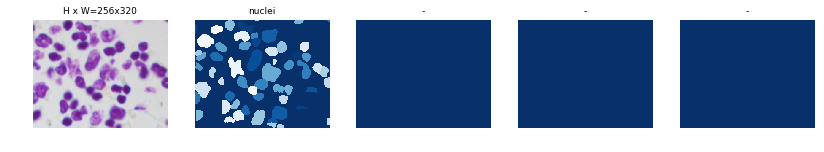

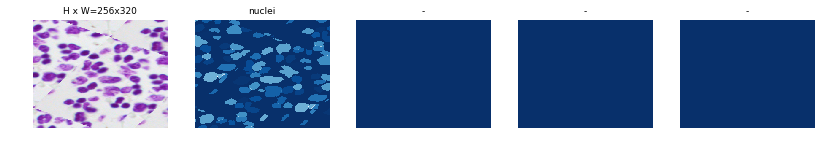

In [54]:
testing_id = 460

# Original image

image = dataset_train.load_image(testing_id)
mask, class_ids = dataset_train.load_mask(testing_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Augmented image
image = dataset_aug.load_image(testing_id)
mask, class_ids = dataset_aug.load_mask(testing_id)
visualize.display_top_masks(image, mask, class_ids, dataset_aug.class_names)

